<a href="https://colab.research.google.com/github/adelfos/ds_advanced/blob/main/3.2%20%D0%9F%D1%80%D0%BE%D0%B4%D0%B2%D0%B8%D0%BD%D1%83%D1%82%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_SEQ2SEQ_(%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0)_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1C72Oa4WU_Tq5lwYfru3lFndo7DD61LSX?)

2. Практика


Начните с подключения необходимых библиотек и модулей. В ходе занятия вы подробнее разберете их назначение.

In [ ]:
# Подключим модуль для загрузки файлов в colab
from google.colab import files

# Подключим модуль numpy для работы с массивами
import numpy as np

# Подгрузим модели кераса
from tensorflow.keras.models import Model, load_model

# Подключим нужные слои
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# Поключим оптимайзеры
from tensorflow.keras.optimizers import RMSprop, Adadelta

# Подключим метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Подключим модуль для one hot кодировки
from tensorflow.keras import utils

# Подключим визуализацию графа модели
from tensorflow.keras.utils import plot_model

# Подключим модуль для работы с yaml - файлами
import yaml

In [ ]:
# Загрузим обучающие тексты

!wget  http://www.manythings.org/anki/rus-eng.zip

--2022-01-30 11:13:10--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14683939 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.00M  --.-KB/s    in 0.1s    

2022-01-30 11:13:10 (124 MB/s) - ‘rus-eng.zip’ saved [14683939/14683939]



In [ ]:
# Убедимся, что файл со текстами загружен
!ls

rus-eng.zip  sample_data


In [ ]:
# Распакуем архив
!unzip -o rus-eng.zip 

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


Читаем из файла 50000 пар русских и английских предложений. Каждая строка содержит английское, русское предложения и служебные данные об источнике информации. Нам нужны только предложения:

In [ ]:
conversations = []                                # Заготовим список для пар фраз

with open("rus.txt", 'r', encoding='utf-8') as f: # Открываем файл словаря в режиме чтения
    lines = f.read().split('\n')                  # Читаем весь файл, режем на строки

# Цикл по строкам
for i,line in enumerate(lines):
    
    if i>50000:                                         # Нам нужно только 50000 первых строк
      break                                             # Заканчиваем цикл
    try:
        input_text, target_text,_ = line.split("\t")    # Берем очередную строку, режем по символу табуляции
        conversations.append([input_text, target_text]) # Заполняем список пар фраз
    except:
        continue                                        # если не получается - идем за следущей строкой

Определим функцию для удаления пробелов перед знаками препинаний. На вход принимает строку или список строк. Выбрасывает пробелы перед знаками препинаний. Возвращает также строку или список строк

In [ ]:
def my_replacer(s):  

    ''' Функция для удаления пробелов перед знаками препинания

        Args: строка или список строк

        Returns: строка или список строк
    '''

    if isinstance(s,str): # Если получили строку

        # Убираем перед знаками препинания пробел и возвращаем
        return s.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')

    if isinstance(s,list): # Если получили список
        ou=[]              # Заготовим пустой список

        for l in s:        # Цикл по строкам из списка
            ou.append(l.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')) # Убираем перед знаками препинания пробел и возвращаем

        # Вернем список строк
        return ou    

Файл с русскими и английскими выражениями часто может быть поврежден или составлен небрежно. К сожалению так бывает. Фразы могут быть получены автоматически из самых разных текстов, в различных форматах и кодировках. Часто просто нет времени проконтроллировать данных процесс, вычитать полученные предложения. 

Почистим выражения, добавим тэги `< start >` `< end >` к ответам:

In [ ]:
# Собираем вопросы и ответы в списки

questions = [] # Переменная для списка входных фраз
answers = []   # Переменная для списка ответных фраз

# Цикл по всем парам фраз 
for con in conversations:                 
  
    if len(con) > 1 :                       # Если ответная фраза содержит более одно двух предложений
        questions.append(my_replacer(con[0])) # То первую в списке фразу отправляем в список входных фраз
        replies = my_replacer(con[1:])        # А ответную составляем из последующих строк
        ans = ' '.join(replies)               # Здесь соберем ответ
        answers.append(ans)                   # Добавим в список ответов
    else:
        continue                              # Иначе идем на новой парой фраз

# Добавим в каждую ответную фразу теги  <START> и <END>
answers = ['<START> ' + s + ' <END>' for s in answers]

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[111])) # Пример входной фразы
print('Ответ : {}'.format(answers[111]))    # Пример ответной фразы

Вопрос : Go now.
Ответ : <START> Иди сейчас. <END>


In [ ]:
len(questions)

50001

Создадим токенайзер из библиотеки Keras. В нашем случае токенайзер просто проиндексирует слова по уменьшению частоты появления и  удалит символы "#$%&()*+-/;<=>@[\\]^_`{|}~\t\n


In [ ]:
# Создадим токенайзер 
tokenizer = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')  

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(questions + answers)         

# Список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())    

# Размер словаря
vocabularySize = len(vocabularyItems)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize))             

Фрагмент словаря : [('start', 1), ('end', 2), ('я', 3), ('i', 4), ('tom', 5), ('том', 6), ('не', 7), ('это', 8), ('you', 9), ('is', 10), ('a', 11), ("i'm", 12), ('ты', 13), ('мы', 14), ('мне', 15), ('the', 16), ('it', 17), ('was', 18), ('we', 19), ('to', 20), ('вы', 21), ('у', 22), ('do', 23), ('it.', 24), ('в', 25), ('он', 26), ('меня', 27), ('tom.', 28), ('my', 29), ("it's", 30), ('you.', 31), ("don't", 32), ('are', 33), ('can', 34), ('me.', 35), ('did', 36), ("you're", 37), ('your', 38), ('he', 39), ('они', 40), ('на', 41), ('был', 42), ('this', 43), ('have', 44), ('что', 45), ('not', 46), ('go', 47), ("i'll", 48), ('that', 49), ('be', 50)]
Размер словаря : 26464


А теперь от слов к цифрам: 

In [ ]:
# Разбиваем текст входных фраз на последовательности индексов
tokenizedQuestions = tokenizer.texts_to_sequences(questions)

# Уточняем длину самой длинной фразы
maxLenQuestions = max([ len(x) for x in tokenizedQuestions])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
encoderForInput = np.array(paddedQuestions)        

# Выведем на экран
print('Пример входной фразы                         : {}'.format(questions[100]))         
print('Пример кодированной входной фразу            : {}'.format(encoderForInput[100]))  
print('Размеры закодированного массива входных фраз : {}'.format(encoderForInput.shape))  
print('Установленная длина входных фраз             : {}'.format(maxLenQuestions))        

Пример входной фразы                         : Freeze!
Пример кодированной входной фразу            : [6316    0    0    0    0    0]
Размеры закодированного массива входных фраз : (50001, 6)
Установленная длина входных фраз             : 6


Те же манипуляции с выходными данными для обучения:

In [ ]:
# Разбиваем текст ответных фраз на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

# Уточняем длину самого длинного ответа
maxLenAnswers = max([len(x) for x in tokenizedAnswers])

# Делаем последовательности одной длины, заполняя нулями более ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
decoderForInput = np.array(paddedAnswers)               

# Выведем на экран
print('Пример оригинального ответа на вход: {}'.format(answers[100]))                         
print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:30]))           
print('Размеры кодированного массива ответов на вход : {}'.format(decoderForInput.shape))     
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))                       

Пример оригинального ответа на вход: <START> Ни с места! <END>
Пример кодированного ответа на вход : [    1  1058    60 11561     2     0     0     0     0     0     0     0]
Размеры кодированного массива ответов на вход : (50001, 12)
Установленная длина ответов на вход : 12


Те же манипуляции с выходными данными для проверки. Убирает тег `< start >`. 

Сетка не будет выдавать фразы с этим тэгом, поэтому и контрольные фразы должны быть без него: 

In [ ]:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

for i in range(len(tokenizedAnswers)) :                  # Для разбитых на последовательности ответов
    tokenizedAnswers[i] = tokenizedAnswers[i][1:]          # Избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post') 

# И сохраняем в виде массива numpy
decoderForOutput = np.array(paddedAnswers)                                             

In [ ]:
# Выведем на экран

print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:21]))   
print('Пример кодированного ответа на выход : {}'.format(decoderForOutput[100][:21]))
print('Размеры кодированного массива ответов на выход : {}'.format(decoderForOutput.shape))  
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers))                    

Пример кодированного ответа на вход : [    1  1058    60 11561     2     0     0     0     0     0     0     0]
Пример кодированного ответа на выход : [ 1058    60 11561     2     0     0     0     0     0     0     0     0]
Размеры кодированного массива ответов на выход : (50001, 12)
Установленная длина вопросов на выход : 12


Создадим энкодер. Он состоит из входного слоя, Embedding-а и одной LSTM. 

На его вход будет подавать предложение,  которое нужно перевести. На выходе - векторы состояния. Они являются исходной информацией для декодера.

In [ ]:
# Создадим энкодер 

encoderInputs = Input(shape=(None , ))                                             # Добавим входной слой
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True)(encoderInputs)  # Добавим эмбеддинг
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding) # Добавим LSTM
encoderStates = [state_h, state_c]                                                 # Соберем выходы lstm  в список    

Вторая часть нейронки - это декодер. Он также содержит входной слой, Embedding и одну LSTM. 

На входе обучающая фраза, на выходе предсказанное слово - в виде длинного-длинного массива One-Hot-Encoding (OHE). 

Массив выглядит `'0,0,0,0,1,0,0,0,0,0,0'`, где позиция единички указывает на индекс слова, присвоенный токенайзером

In [ ]:
# Создадим декодер 

decoderInputs = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs)    # Добавим эмбеддинг
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates) # Прогоним выход embedding через LSTM
decoderDense = Dense(vocabularySize, activation='softmax')                           # Создадим dense слой
output = decoderDense (decoderOutputs)                                               # Прогоним  выход LSTM через DENSE

Пора собирать кодер и декодер вместе. 

Посмотрим на структуру построенный сети. Заметим, что при обучении будем минимизировать sparse_categorical_crossentropy. 

Часто, при предсказании дискретных классов используют известную вам categorical_crossentropy. Для ее использовании слова обучающей выборки слова  необходимо преобразовывать в OHE. Все бы хорошо, но для хранения одного слова придется потратить очень много памяти. Вместо одного значения - 1 единицу и кучу нулей, по числу возможных слов. 

Sparse_categorical_crossentropy - позволяет хранить 1 токен. При обучении он сам развернет обучающее слово в OHE

In [ ]:
# Собираем модель

model = Model([encoderInputs, decoderInputs], output)

In [ ]:
# Компилиуем модель

model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')

In [ ]:
# Выведем на экран информацию о построенной модели нейросети

print(model.summary())  

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 200)    5292800     ['input_5[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 200)    5292800     ['input_6[0][0]']                
                                                                                            

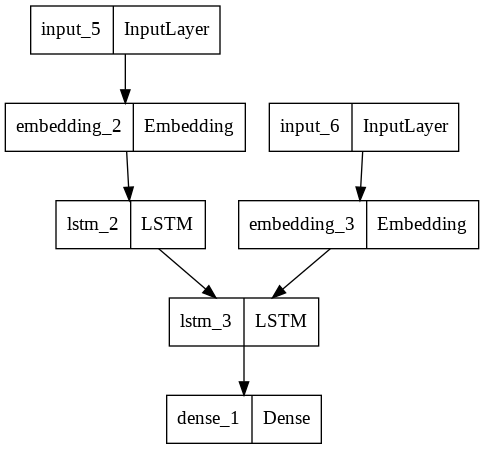

In [ ]:
# Построим график для визуализации слоев и связей между ними

plot_model(model, to_file='model.png')

Пора обучаться. И не забудем сохранить обученную модель на диске

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=256, epochs=30) 

# Сохраним модель на диске
model.save( 'content/model_30epochs(rms).h5' )

Epoch 1/30
196/196 [==============================] - 8s 40ms/step - loss: 0.4792
Epoch 2/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4710
Epoch 3/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4622
Epoch 4/30
196/196 [==============================] - 8s 40ms/step - loss: 0.4532
Epoch 5/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4453
Epoch 6/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4393
Epoch 7/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4331
Epoch 8/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4270
Epoch 9/30
196/196 [==============================] - 8s 40ms/step - loss: 0.4214
Epoch 10/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4156
Epoch 11/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4101
Epoch 12/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4043
Epoch 13/30
1

In [ ]:
# Сохраним веса модели
model.save_weights('s2s_30epochs.h5')

Уменьшающиеся при обучении лоссы - это хорошо, но оценить качество переведенных фраз может (пока что)  человек -  носитель языка.
Давайте перестроим нашу модель для перевода.

Создадим рабочие модели для перевода.

В теле функции производится сборка сети для перевода фраз из уже обученных слоев.

1. Энкодер оставляем как есть  для задачи seq2seq он не меняется
2. Декодеру на вход подаем финальные состояния энкодера.Пропускаем через предобученный ранее LSTM и Dense слои
Возвращает модели энкодера и декодера

In [ ]:
def makeInferenceModels():

    ''' Функция сборки сети для перевода фраз из уже обученных слов

        Args: -

        Returns: модели энкодера и декодера   
    '''    

    # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
    encoderModel = Model(encoderInputs, encoderStates) 

    # Создадим модель декодера
    decoderStateInput_h = Input(shape=(200 ,)) # Добавим входной слой для state_h
    decoderStateInput_c = Input(shape=(200 ,)) # Добавим входной слой для state_c

    # Соберем оба inputs вместе и запишем в decoderStatesInputs
    decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] 

    # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
    decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs) 
    
    # LSTM даст нам новые состояния
    decoderStates = [state_h, state_c]            
    
    # И ответы, которые мы пропустим через полносвязный слой с софтмаксом
    decoderOutputs = decoderDense(decoderOutputs) 

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
    decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

    # Вернем рабочие модели энкодера и декодера  
    return encoderModel , decoderModel

Сервисная функция для перевода произвольной фразы в токены. Функция разбирает фразу на слова. Для каждого слова находит свой индекс. Его подскажет токенайзер. И дополняет полученный список индексов нулями до максимальной длины.
Используется для подготовки фразы к ее переводу.
Принимает на вход строку, отдает список токенов

In [ ]:
def strToTokens(sentence: str):      

    ''' Функция для удаления пробелов перед знаками препинания

        Args: фраза

        Returns: список токенов
    '''

    # Почистим фразу
    tmp_sent = my_replacer(sentence)  
    
    # Приведем предложение к нижнему регистру и разбирает на слова
    words = tmp_sent.lower().split()  
    
    # Создадим список для последовательности токенов/индексов
    tokensList = list()               

    # Для каждого слова в предложении
    for word in words:
        
        try:
            tokensList.append(tokenizer.word_index[word]) # Определяем токенайзером индекс и добавляем в список
        except:
            pass # Слова нет - просто игнорируем его

    # Вернёт входную фразу в виде последовательности индексов
    if tokensList:
        return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

    # Фраза из незнакомых слов - вернем None 
    return None

In [ ]:
import numpy as np
emptyTargetSeq = np.zeros((1, 1))


emptyTargetSeq[0, 0] = 5

emptyTargetSeq

array([[5.]])

Запускаем функцию для построения модели кодера и декодера

In [ ]:
encModel , decModel = makeInferenceModels() 

Начинаем перевод текстов. Нейронка попросит на вход 6 (лучше простеньких) фраз и выдаст то, что она об этом думает. Работаем в цикле.

Начнем с подготовки:

- Сначала запросим фразу у пользователя, переведем ее в токены при помощи функции `strToTokens()` и поместим результат в переменную `qua`. 
- Проверим, не состоит ли фраза из полностью незнакомых слов.
- Создадим массив `emptyTargetSeq` вида [[0.]], поместим в его начало слово `start` в виде индекса. 
- Определим условие остановки генерации `stopCondition` 
- Создадим переменную `decodedTranslation` для сборки ответа
- Прогоним фразу через энкодер и поместим результат в переменную `statesValues`

Далее, пока не сработало стоп-условие, в модель декодера подаем пустую последовательность со словом 'start' и состояния, предсказанные кодером по заданному вопросу. Декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния. Поместим результат в переменные `decOutputs , h , c`.

Обработаем предсказанное слово функцией `np.argmax`, получим его индекс и поместим резуьтат в переменную `sampledWordIndex`.

Создадим переменную `sampledWord` для слов, преобразованных в естественный язык.

Переберем в цикле все индексы токенайзера, и если индекс выбранного слова соответствует какому-то индексу из словаря, то слово, идущее под этим индексом в словаре, добавляется в итоговый ответ. Плюс выбранное слово фиксируем в переменную sampledWord. Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа - срабатывает стоп-условие и прекращаем генерацию.

Создаем пустой массив, заносим в него индекс выбранного слова. Сохраняем в список `statesValues` состояния, обновленные декодером.

Выводим ответ сгенерированный декодером.

In [ ]:
# Цикл по количеству входных фраз - их 6

for _ in range(6):

    # подготовка
    
    qua  = strToTokens(input('Исходное предложение на английском: '))
    if qua is None:                                      
        print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
        continue                                             # Пойдем за следущей фразой

    emptyTargetSeq = np.zeros((1, 1))                    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] 
    stopCondition = False                                
    decodedTranslation = '' 
    statesValues = encModel.predict(qua)                              

    # пока не сработало стоп-условие
    while not stopCondition:                             

        # В модель декодера подадим пустую последовательность со словом 'start' и состояния
        decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
        # Получим индекс предсказанного слова.
        sampledWordIndex = np.argmax( decOutputs[0, 0, :]) 
        # Создаем переменную для преобразованных на естественный язык слов
        sampledWord = None                                 

        # Переберем в цикле все индексы токенайзера
        for word, index in tokenizer.word_index.items():
        
            # Если индекс выбранного слова соответствует какому-то индексу из словаря
            if sampledWordIndex == index:              
                # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
                decodedTranslation += ' {}'.format(word) 
                # Выбранное слово фиксируем в переменную sampledWord
                sampledWord = word                       
        
        # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
        if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
            stopCondition = True # Срабатывает стоп-условие и прекращаем генерацию

        # Создаем пустой массив
        emptyTargetSeq = np.zeros((1, 1))       
        
        # Заносим в него индекс выбранного слова
        emptyTargetSeq[0, 0] = sampledWordIndex 
        
        # Записываем состояния, обновленные декодером 
        statesValues = [h, c]   

        # И продолжаем цикл с обновленными параметрами                
                                                
    # Выводим ответ сгенерированный декодером
    print("Перевод: ", decodedTranslation) 

Исходное предложение на английском: what is your name?
Перевод:   как твоё имя? end
Исходное предложение на английском: How are you?
Перевод:   как у вас дела? end
Исходное предложение на английском: what are you doing?
Перевод:   что ты будешь делает? end
Исходное предложение на английском: how old are you?
Перевод:   сколько вам лет? end
Исходное предложение на английском: what is your mood today?
Перевод:   как твой имя? end
Исходное предложение на английском: are you angry?
Перевод:   ты злишься? end


Что сказать... Фразы подчас смешные, но общий смысл уже где-то рядом...

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1C72Oa4WU_Tq5lwYfru3lFndo7DD61LSX?authuser=1#scrollTo=nH1qsHSh9CF7)

2. Практика
